# Image classification: French cheeses

## Import TensorFlow and other libraries

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Import dataset

In this notebook we use the dataset ```auto_dataset_cleaned```, which uses a script to automatically download images from the internet, that are then checked manually.


In [35]:

data_dir = pathlib.Path('data/auto_dataset_cleaned')
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.jpeg')))
print(f"Found {image_count} jpg and jpeg images.")

Found 3619 jpg and jpeg images.


## Create a tf.keras dataset

In [36]:
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.04,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.04,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

Found 3622 files belonging to 15 classes.
Using 3478 files for training.
Found 3622 files belonging to 15 classes.
Using 144 files for validation.
Class names: ["Bleu d'Auvergne", 'Brie de Meaux', 'Brie de Melun', 'Camembert de Normandie', 'Cantal', 'Comte', 'Emmenthal de Savoie', "Fourme d'Ambert", 'Fourme de Montbrison', 'Mimolette', 'Morbier', 'Ossau-Iraty', 'Rocamadour', 'Roquefort', 'Saint-Nectaire']


## Visualize the data

Here are the first nine images from the training dataset:

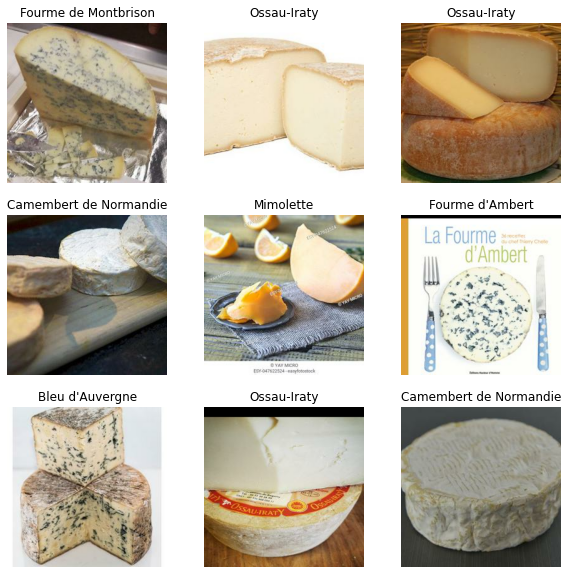

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [39]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [40]:
import pickle

model_path = pathlib.Path('models/auto_cleaned/model0')

def load_model(reset):
  if reset:
    tf.keras.backend.clear_session()
    num_classes = len(class_names)
    model = Sequential([
      data_augmentation,
      layers.Rescaling(1./255),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(128, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.summary()
    return model
  else:
    model = keras.models.load_model(model_path)
    model.summary()
    return model

def update_history(reset, history):
  if reset:
    training_history = {'acc':[], 'val_acc':[], 'loss':[], 'val_loss':[], 'epochs':0}
  else:
    training_history = pickle.load(open(model_path / 'training_history', 'rb'))
  training_history['acc'] += history.history['accuracy']
  training_history['val_acc'] += history.history['val_accuracy']
  training_history['loss'] += history.history['loss']
  training_history['val_loss'] += history.history['val_loss']
  training_history['epochs'] += epochs
  with open(model_path / 'training_history', 'wb') as file_pi:
    pickle.dump(training_history, file_pi)
  return training_history

In [41]:
reset = False
epochs = 5

model = load_model(reset=reset)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

model.save(model_path)
training_history = update_history(reset=reset, history=history)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1

## Visualize training results

range(1, 37)


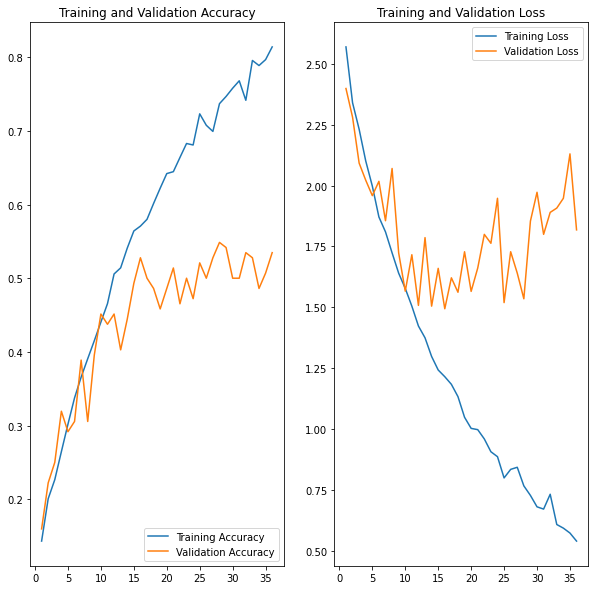

In [ ]:
epochs_range = range(1, 1+training_history['epochs'])
print(epochs_range)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_history['acc'], label='Training Accuracy')
plt.plot(epochs_range, training_history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_history['loss'], label='Training Loss')
plt.plot(epochs_range, training_history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [ ]:
from IPython.display import display

def cheezam(filepath : str):
    img = tf.keras.utils.load_img(filepath, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    display( PIL.Image.open(filepath).resize((256,256)))

    print(
    "This cheese is most likely a {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

    

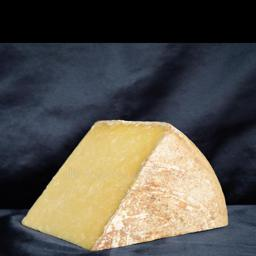

This cheese is most likely a Cantal with a 95.01 percent confidence.


In [ ]:
cheezam('data/test/test2.jpg')

10


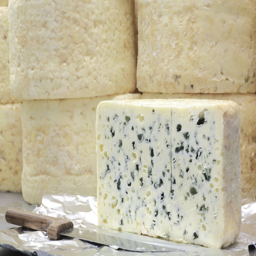

This cheese is most likely a Roquefort with a 89.26 percent confidence.


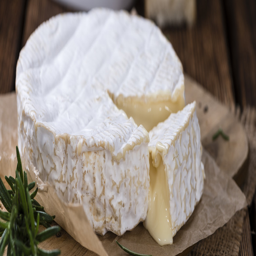

This cheese is most likely a Camembert de Normandie with a 93.52 percent confidence.


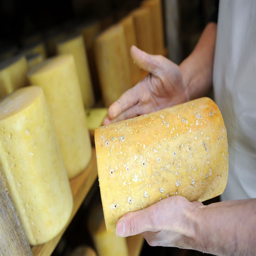

This cheese is most likely a Fourme de Montbrison with a 99.16 percent confidence.


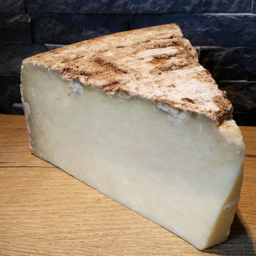

This cheese is most likely a Ossau-Iraty with a 58.57 percent confidence.


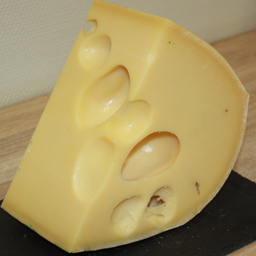

This cheese is most likely a Cantal with a 51.82 percent confidence.


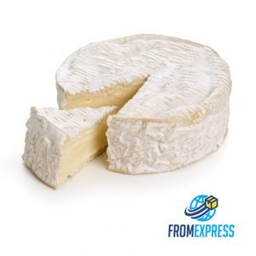

This cheese is most likely a Camembert de Normandie with a 96.77 percent confidence.


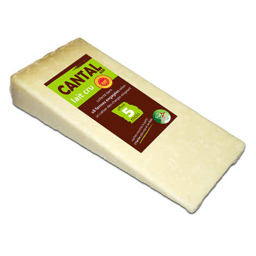

This cheese is most likely a Cantal with a 99.20 percent confidence.


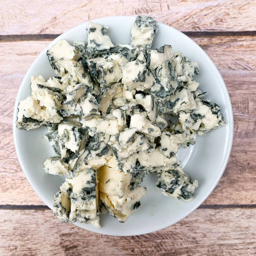

This cheese is most likely a Roquefort with a 66.04 percent confidence.


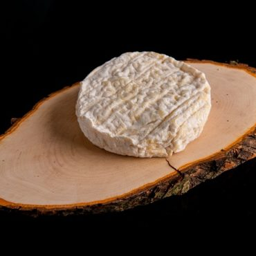

This cheese is most likely a Saint-Nectaire with a 61.11 percent confidence.


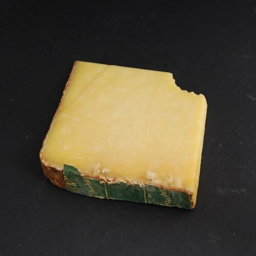

This cheese is most likely a Cantal with a 99.35 percent confidence.


In [ ]:
import random
test_dir = pathlib.Path('data/sample_dataset')
test_paths_total = list(test_dir.glob('*/*.jpg'))
nb_test, nb_test_total = 10, len(test_paths_total)
test_paths = random.sample(test_paths_total, nb_test)
print(len(test_paths))
for test_path in test_paths:
    cheezam(test_path)

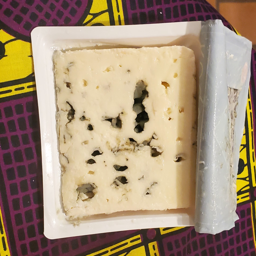

This cheese is most likely a Roquefort with a 89.89 percent confidence.


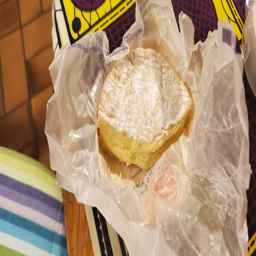

This cheese is most likely a Fourme de Montbrison with a 90.97 percent confidence.


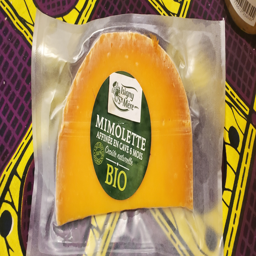

This cheese is most likely a Mimolette with a 91.58 percent confidence.


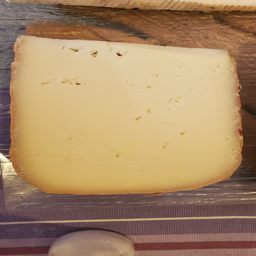

This cheese is most likely a Emmenthal de Savoie with a 64.57 percent confidence.


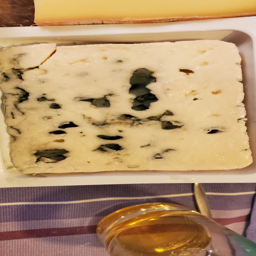

This cheese is most likely a Roquefort with a 64.52 percent confidence.


In [ ]:
photos_brice_dir = pathlib.Path('data/photos_brice')
photos_brice_paths = list(photos_brice_dir.glob('*.jpg'))
for photo in photos_brice_paths:
    cheezam(photo)